In [ ]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import warnings

2. DISPALY SETTING

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
sklearn.set_config(transform_output="pandas")

In [4]:
warnings.filterwarnings("ignore")

3. Read the data 

In [5]:
path = r'C:\Users\mukti\Desktop\Flight_prediction_sagemaker\data\train.csv'

train = pd.read_csv(path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Multiple Carriers,2019-05-18,Delhi,Cochin,08:30:00,19:00:00,630,1.0,No Info,9205
1,Spicejet,2019-03-09,Banglore,New Delhi,10:20:00,18:15:00,475,1.0,No Info,7294
2,Jet Airways,2019-06-06,Delhi,Cochin,05:30:00,19:00:00,810,2.0,In-flight meal not included,10368
3,Jet Airways,2019-03-21,Delhi,Cochin,06:20:00,04:25:00,1325,2.0,No Info,12273
4,Jet Airways,2019-04-21,Banglore,Delhi,19:50:00,22:50:00,180,0.0,In-flight meal not included,4544
...,...,...,...,...,...,...,...,...,...,...
635,Jet Airways,2019-05-21,Kolkata,Banglore,09:35:00,23:35:00,840,1.0,No Info,14151
636,Jet Airways,2019-05-12,Kolkata,Banglore,09:35:00,21:05:00,690,1.0,No Info,14151
637,Jet Airways,2019-06-03,Delhi,Cochin,15:00:00,04:25:00,805,1.0,No Info,14714
638,Multiple Carriers,2019-03-03,Delhi,Cochin,13:55:00,01:35:00,700,1.0,No Info,17057


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [7]:
X_train = train.drop(columns="price")
y_train = train.price.copy()

## transformation operation

In [8]:
X_train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info'],
      dtype='object')

## airline

In [9]:
X_train.airline

0      Multiple Carriers
1               Spicejet
2            Jet Airways
3            Jet Airways
4            Jet Airways
             ...        
635          Jet Airways
636          Jet Airways
637          Jet Airways
638    Multiple Carriers
639          Jet Airways
Name: airline, Length: 640, dtype: object

In [10]:
air_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

air_transformer.fit_transform(X_train.loc[:, ["airline"]])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Other
0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0
...,...,...,...,...
635,0.0,0.0,1.0,0.0
636,0.0,0.0,1.0,0.0
637,0.0,0.0,1.0,0.0
638,0.0,0.0,0.0,1.0


### date_of_journey

In [13]:
X_train.date_of_journey

0      2019-05-18
1      2019-03-09
2      2019-06-06
3      2019-03-21
4      2019-04-21
          ...    
635    2019-05-21
636    2019-05-12
637    2019-06-03
638    2019-03-03
639    2019-03-06
Name: date_of_journey, Length: 640, dtype: object

In [16]:
feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]

doj_transformer = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
	("scaler", MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:, ["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.666667,0.647059,0.833333,0.661017
1,0.000000,0.058824,0.833333,0.067797
2,1.000000,0.823529,0.500000,0.822034
3,0.000000,0.176471,0.500000,0.169492
4,0.333333,0.411765,1.000000,0.432203
...,...,...,...,...
635,0.666667,0.705882,0.166667,0.686441
636,0.666667,0.588235,1.000000,0.610169
637,1.000000,0.823529,0.000000,0.796610
638,0.000000,0.000000,1.000000,0.016949


### source and destination

In [18]:
X_train.source

0         Delhi
1      Banglore
2         Delhi
3         Delhi
4      Banglore
         ...   
635     Kolkata
636     Kolkata
637       Delhi
638       Delhi
639       Delhi
Name: source, Length: 640, dtype: object

In [19]:
X_train.destination

0         Cochin
1      New Delhi
2         Cochin
3         Cochin
4          Delhi
         ...    
635     Banglore
636     Banglore
637       Cochin
638       Cochin
639       Cochin
Name: destination, Length: 640, dtype: object

In [20]:

location_subset = X_train.loc[:, ["source", "destination"]]
location_subset

,source,destination
0,Delhi,Cochin
1,Banglore,New Delhi
2,Delhi,Cochin
3,Delhi,Cochin
4,Banglore,Delhi
...,...,...
635,Kolkata,Banglore
636,Kolkata,Banglore
637,Delhi,Cochin
638,Delhi,Cochin


In [22]:
location_pipe1 = Pipeline(steps=[
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", MeanEncoder()),
	("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,1.102072,1.088300
1,-0.515915,-0.360057
2,1.102072,1.088300
3,1.102072,1.088300
4,-0.515915,-1.954710
...,...,...
635,-0.440064,-0.461317
636,-0.440064,-0.461317
637,1.102072,1.088300
638,1.102072,1.088300


In [23]:
np.union1d(
	X_train.source.unique(),
	X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [24]:
def is_north(X):
	columns = X.columns.to_list()
	north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
	return (
		X
		.assign(**{
			f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
			for col in columns
		})
		.drop(columns=columns)
	)


FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,0,1
2,1,0
3,1,0
4,0,1
...,...,...
635,1,0
636,1,0
637,1,0
638,1,0


In [25]:
location_transformer = FeatureUnion(transformer_list=[
	("part1", location_pipe1),
	("part2", FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,1.102072,1.088300,1,0
1,-0.515915,-0.360057,0,1
2,1.102072,1.088300,1,0
3,1.102072,1.088300,1,0
4,-0.515915,-1.954710,0,1
...,...,...,...,...
635,-0.440064,-0.461317,1,0
636,-0.440064,-0.461317,1,0
637,1.102072,1.088300,1,0
638,1.102072,1.088300,1,0


## dep_time and arrival_time

In [28]:
X_train.dep_time

0      08:30:00
1      10:20:00
2      05:30:00
3      06:20:00
4      19:50:00
         ...   
635    09:35:00
636    09:35:00
637    15:00:00
638    13:55:00
639    18:15:00
Name: dep_time, Length: 640, dtype: object

In [29]:
X_train.arrival_time

0      19:00:00
1      18:15:00
2      19:00:00
3      04:25:00
4      22:50:00
         ...   
635    23:35:00
636    21:05:00
637    04:25:00
638    01:35:00
639    04:25:00
Name: arrival_time, Length: 640, dtype: object

In [30]:
time_subset = X_train.loc[:, ["dep_time", "arrival_time"]]
time_subset

,dep_time,arrival_time
0,08:30:00,19:00:00
1,10:20:00,18:15:00
2,05:30:00,19:00:00
3,06:20:00,04:25:00
4,19:50:00,22:50:00
...,...,...
635,09:35:00,23:35:00
636,09:35:00,21:05:00
637,15:00:00,04:25:00
638,13:55:00,01:35:00


In [31]:
time_pipe1 = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
	("scaler", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.347826,0.545455,0.826087,0.000000
1,0.434783,0.363636,0.782609,0.272727
2,0.217391,0.545455,0.826087,0.000000
3,0.260870,0.363636,0.173913,0.454545
4,0.826087,0.909091,0.956522,0.909091
...,...,...,...,...
635,0.391304,0.636364,1.000000,0.636364
636,0.391304,0.636364,0.913043,0.090909
637,0.652174,0.000000,0.173913,0.454545
638,0.565217,1.000000,0.043478,0.636364


In [32]:
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
	columns = X.columns.to_list()
	X_temp = X.assign(**{
		col: pd.to_datetime(X.loc[:, col]).dt.hour
		for col in columns
	})

	return (
		X_temp
		.assign(**{
			f"{col}_part_of_day": np.select(
				[X_temp.loc[:, col].between(morning, noon, inclusive="left"),
				 X_temp.loc[:, col].between(noon, eve, inclusive="left"),
				 X_temp.loc[:, col].between(eve, night, inclusive="left")],
				["morning", "afternoon", "evening"],
				default="night"
			)
			for col in columns
		})
		.drop(columns=columns)
	)

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,morning,evening
1,morning,evening
2,morning,evening
3,morning,morning
4,evening,night
...,...,...
635,morning,night
636,morning,night
637,afternoon,morning
638,afternoon,night


In [33]:
time_pipe2 = Pipeline(steps=[
	("part", FunctionTransformer(func=part_of_day)),
	("encoder", CountFrequencyEncoder()),
	("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,1.000000,0.675439
1,1.000000,0.675439
2,1.000000,0.675439
3,1.000000,1.000000
4,0.299492,0.991228
...,...,...
635,1.000000,0.991228
636,1.000000,0.991228
637,0.000000,1.000000
638,0.000000,0.991228


In [34]:
time_transformer = FeatureUnion(transformer_list=[
	("part1", time_pipe1),
	("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.347826,0.545455,0.826087,0.000000,1.000000,0.675439
1,0.434783,0.363636,0.782609,0.272727,1.000000,0.675439
2,0.217391,0.545455,0.826087,0.000000,1.000000,0.675439
3,0.260870,0.363636,0.173913,0.454545,1.000000,1.000000
4,0.826087,0.909091,0.956522,0.909091,0.299492,0.991228
...,...,...,...,...,...,...
635,0.391304,0.636364,1.000000,0.636364,1.000000,0.991228
636,0.391304,0.636364,0.913043,0.090909,1.000000,0.991228
637,0.652174,0.000000,0.173913,0.454545,0.000000,1.000000
638,0.565217,1.000000,0.043478,0.636364,0.000000,0.991228


## duration

In [36]:
X_train.duration

0       630
1       475
2       810
3      1325
4       180
       ... 
635     840
636     690
637     805
638     700
639     610
Name: duration, Length: 640, dtype: int64

In [37]:
(
	X_train
	.duration
	.quantile([0.25, 0.5, 0.75])
	.values
	.reshape(-1, 1)
	# .shape
)

array([[175.  ],
       [527.5 ],
       [891.25]])

In [38]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
		if not self.variables:
			self.variables = X.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)

In [39]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X_train)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,0.0,0.0,1.000000,1.000000
1,0.0,0.0,1.000000,1.000000
2,0.0,0.0,0.904837,0.904837
3,0.0,0.0,0.904837,0.904837
4,0.0,0.0,0.904837,0.904837
...,...,...,...,...
635,0.0,0.0,1.000000,1.000000
636,0.0,0.0,1.000000,1.000000
637,0.0,0.0,1.000000,1.000000
638,0.0,0.0,1.000000,1.000000


In [40]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [41]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

In [42]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.330399,-0.100953,-0.071011,2.0,0,-0.007496
1,-0.330399,-0.100953,-0.071011,2.0,0,-0.325123
2,-0.330399,-0.100953,-0.071011,2.0,0,0.361360
3,-0.330399,-0.100953,-0.071011,2.0,1,1.416698
4,2.946623,-0.100953,-0.071011,1.0,0,-0.929637
...,...,...,...,...,...,...
635,-0.330399,-0.100953,-0.071011,2.0,0,0.422836
636,-0.330399,-0.100953,-0.071011,2.0,0,0.115456
637,-0.330399,-0.100953,-0.071011,2.0,0,0.351114
638,-0.330399,-0.100953,-0.071011,2.0,0,0.135948


## total_stops

In [43]:
X_train.total_stops

0      1.0
1      1.0
2      2.0
3      2.0
4      0.0
      ... 
635    1.0
636    1.0
637    1.0
638    1.0
639    1.0
Name: total_stops, Length: 640, dtype: float64

In [44]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,1.0,0
1,1.0,0
2,2.0,0
3,2.0,0
4,0.0,1
...,...,...
635,1.0,0
636,1.0,0
637,1.0,0
638,1.0,0


## additional info

In [45]:
X_train.additional_info

0                          No Info
1                          No Info
2      In-flight meal not included
3                          No Info
4      In-flight meal not included
                  ...             
635                        No Info
636                        No Info
637                        No Info
638                        No Info
639                        No Info
Name: additional_info, Length: 640, dtype: object

In [46]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,1.0,0.0
4,1.0,0.0,0.0
...,...,...,...
635,0.0,1.0,0.0
636,0.0,1.0,0.0
637,0.0,1.0,0.0
638,0.0,1.0,0.0


In [47]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [48]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [49]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0
2,1.0,0.0,0.0,1
3,0.0,1.0,0.0,0
4,1.0,0.0,0.0,1
...,...,...,...,...
635,0.0,1.0,0.0,0
636,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0
638,0.0,1.0,0.0,0


Final column Transformers

In [50]:
column_transformer = ColumnTransformer(transformers=[
	("air", air_transformer, ["airline"]),
	("doj", doj_transformer, ["date_of_journey"]),
	("location", location_transformer, ["source", 'destination']),
	("time", time_transformer, ["dep_time", "arrival_time"]),
	("dur", duration_transformer, ["duration"]),
	("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
], remainder="passthrough")

column_transformer.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,0.0,0.0,1.0,0.666667,0.647059,0.833333,0.661017,1.102072,1.088300,1,0,0.347826,0.545455,0.826087,0.000000,1.000000,0.675439,-0.330399,-0.100953,-0.071011,2.0,0,-0.007496,1.0,0,0.0,1.0,0.0,0
1,0.0,0.0,0.0,1.0,0.000000,0.058824,0.833333,0.067797,-0.515915,-0.360057,0,1,0.434783,0.363636,0.782609,0.272727,1.000000,0.675439,-0.330399,-0.100953,-0.071011,2.0,0,-0.325123,1.0,0,0.0,1.0,0.0,0
2,0.0,0.0,1.0,0.0,1.000000,0.823529,0.500000,0.822034,1.102072,1.088300,1,0,0.217391,0.545455,0.826087,0.000000,1.000000,0.675439,-0.330399,-0.100953,-0.071011,2.0,0,0.361360,2.0,0,1.0,0.0,0.0,1
3,0.0,0.0,1.0,0.0,0.000000,0.176471,0.500000,0.169492,1.102072,1.088300,1,0,0.260870,0.363636,0.173913,0.454545,1.000000,1.000000,-0.330399,-0.100953,-0.071011,2.0,1,1.416698,2.0,0,0.0,1.0,0.0,0
4,0.0,0.0,1.0,0.0,0.333333,0.411765,1.000000,0.432203,-0.515915,-1.954710,0,1,0.826087,0.909091,0.956522,0.909091,0.299492,0.991228,2.946623,-0.100953,-0.071011,1.0,0,-0.929637,0.0,1,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,1.0,0.0,0.666667,0.705882,0.166667,0.686441,-0.440064,-0.461317,1,0,0.391304,0.636364,1.000000,0.636364,1.000000,0.991228,-0.330399,-0.100953,-0.071011,2.0,0,0.422836,1.0,0,0.0,1.0,0.0,0
636,0.0,0.0,1.0,0.0,0.666667,0.588235,1.000000,0.610169,-0.440064,-0.461317,1,0,0.391304,0.636364,0.913043,0.090909,1.000000,0.991228,-0.330399,-0.100953,-0.071011,2.0,0,0.115456,1.0,0,0.0,1.0,0.0,0
637,0.0,0.0,1.0,0.0,1.000000,0.823529,0.000000,0.796610,1.102072,1.088300,1,0,0.652174,0.000000,0.173913,0.454545,0.000000,1.000000,-0.330399,-0.100953,-0.071011,2.0,0,0.351114,1.0,0,0.0,1.0,0.0,0
638,0.0,0.0,0.0,1.0,0.000000,0.000000,1.000000,0.016949,1.102072,1.088300,1,0,0.565217,1.000000,0.043478,0.636364,0.000000,0.991228,-0.330399,-0.100953,-0.071011,2.0,0,0.135948,1.0,0,0.0,1.0,0.0,0


## feature selection

In [61]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

## putting it all together

In [62]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Jet Airways,doj__date_of_journey_week,doj__date_of_journey_day_of_year,dur__duration_cat,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,0.647059,0.661017,2.0,-0.007496,1.0,0
1,0.0,0.058824,0.067797,2.0,-0.325123,1.0,0
2,1.0,0.823529,0.822034,2.0,0.361360,2.0,0
3,1.0,0.176471,0.169492,2.0,1.416698,2.0,0
4,1.0,0.411765,0.432203,1.0,-0.929637,0.0,1
...,...,...,...,...,...,...,...
635,1.0,0.705882,0.686441,2.0,0.422836,1.0,0
636,1.0,0.588235,0.610169,2.0,0.115456,1.0,0
637,1.0,0.823529,0.796610,2.0,0.351114,1.0,0
638,0.0,0.000000,0.016949,2.0,0.135948,1.0,0


In [63]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': np.float64(-0.005558381635596336),
 'air__airline_Indigo': np.float64(0.09571856116613797),
 'air__airline_Jet Airways': np.float64(0.21018447210565086),
 'air__airline_Other': np.float64(0.047395556975609855),
 'doj__date_of_journey_month': np.float64(0.07517585884961624),
 'doj__date_of_journey_week': np.float64(0.17549038447561702),
 'doj__date_of_journey_day_of_week': np.float64(-0.019541517363797906),
 'doj__date_of_journey_day_of_year': np.float64(0.19135458371331318),
 'location__source': np.float64(0.0891699132764245),
 'location__destination': np.float64(0.09373753499579456),
 'location__source_is_north': np.float64(0.00887767870237055),
 'location__destination_is_north': np.float64(0.00887767870237055),
 'time__dep_time_hour': np.float64(-0.002113632128901921),
 'time__dep_time_minute': np.float64(0.018423400431081666),
 'time__arrival_time_hour': np.float64(0.0275730834619801),
 'time__arrival_time_minute': np.float64(0.015062821963902443),
 'time_

In [54]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'info__additional_info_Other': np.float64(-0.06929553795516163),
 'doj__date_of_journey_day_of_week': np.float64(-0.019541517363797906),
 'time__dep_time_part_of_day': np.float64(-0.00649334113801429),
 'dur__duration_rbf_75': np.float64(-0.006286436322094691),
 'air__airline_Air India': np.float64(-0.005558381635596336),
 'time__dep_time_hour': np.float64(-0.002113632128901921),
 'dur__duration_rbf_50': np.float64(-0.0007274977682883987),
 'info__additional_info_In-flight meal not included': np.float64(-4.598568902240233e-05),
 'info__additional_info_No Info': np.float64(0.0020284579705908876),
 'info__additional_info': np.float64(0.0020284579705908876),
 'time__arrival_time_part_of_day': np.float64(0.002360247413386659),
 'location__source_is_north': np.float64(0.00887767870237055),
 'location__destination_is_north': np.float64(0.00887767870237055),
 'time__arrival_time_minute': np.float64(0.015062821963902443),
 'time__dep_time_minute': np.float64(0.018423400431081666),
 'time__arr

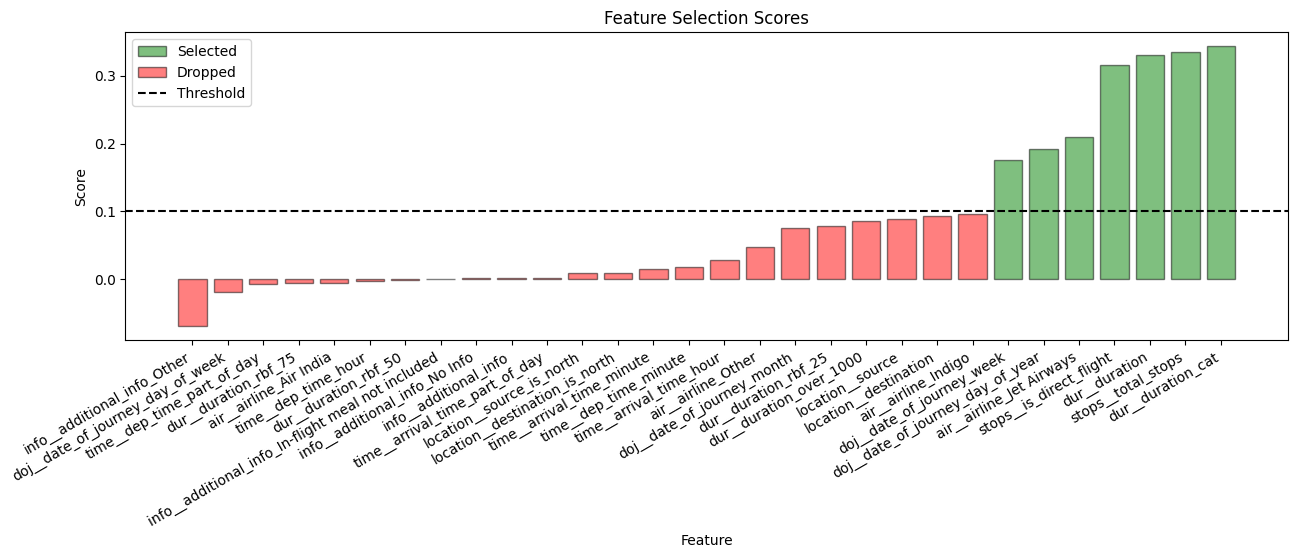

In [64]:
THRESHOLD = 0.10

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()